In [463]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
import skimage
import math

In [464]:
os.getcwd()
os.chdir(r'C:\Users\sherw\OneDrive\Desktop\CV_HW3\Imgs')

# p1:

In [465]:
def load_images_from_folder(folder):
    images = []
    images_rgb = []
    images_names = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        img_rgb = cv2.imread(os.path.join(folder,filename))
        images_rgb.append(img_rgb)
        
        ## resizing images:
        img = cv2.resize(img, (256,256), interpolation = cv2.INTER_CUBIC)
        images_names.append(filename.split('_')[0])
        
        ## preprocessing:
        if img is not None:
            images.append(img.astype(np.float32) / 255)
    return images,images_names, images_rgb

In [466]:
images,images_labels, images_rgb = load_images_from_folder('.')

In [467]:
reference_images,reference_labels = [],[]
test_images,test_labels = [],[]
test_images_rgb = []
for i in range(len(images)):
    if i%7 == 0:
        reference_images.append(images[i])
        reference_labels.append(images_labels[i])
    else:
        test_images.append(images[i])
        test_labels.append(images_labels[i])
        test_images_rgb.append(images_rgb[i])

In [468]:
len(images)

21

# p2:

In [469]:
kernels = []
for theta in range(8):
    theta = theta / 8. * np.pi
    for sigma in (1,3,5):
        for gamma in (1,0.5,0.25):
            kernel = cv2.getGaborKernel((21,21), sigma, theta, 10,\
                                        gamma, 0, cv2.CV_32F)
#             kernel /= math.sqrt((kernel * kernel).sum())
            kernels.append(kernel)

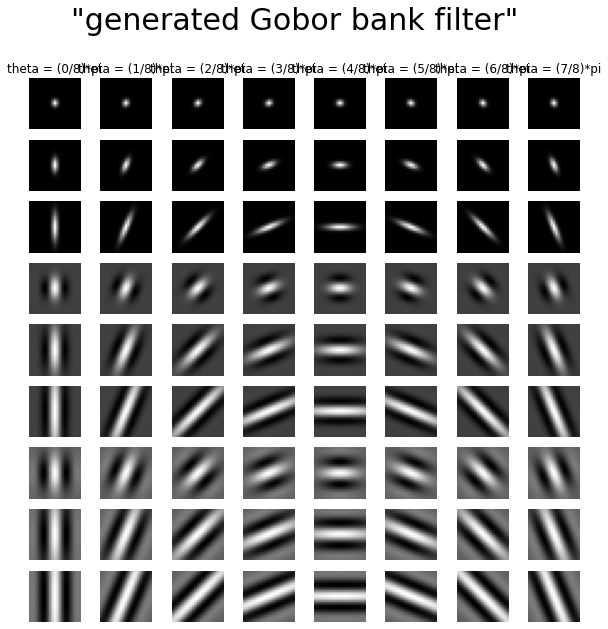

In [470]:
ncols=8
fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(10,10))

count = 0
num = 0
for i in range(ncols):
    for ax in axes:
        if count%9 == 0:
            ax[i].set_title('theta = ({}/8)*pi'.format(num))
            num += 1
        ax[i].imshow(kernels[count],'gray')
        ax[i].axis('off')
        count += 1
plt.suptitle('"generated Gobor bank filter"',size = 30)
plt.savefig('../Outputs/p2.jpg')
plt.show()

# p3:

In [471]:
def feature(image,kernell):
    feature = cv2.filter2D(image, -1, kernell)
    return np.array(feature)

In [472]:
def feature2(image,kernell):
    feature = [np.mean(cv2.filter2D(image, -1, kernell)),np.var(cv2.filter2D(image, -1, kernell))]
    return np.array(feature)

In [473]:
def features(image,kernel_bank):
    features = []
    for ker in kernel_bank:
        features.append(cv2.filter2D(image, -1, ker))
    return np.array(features)

In [474]:
def features2(image,kernel_bank):
    features = []
    for ker in kernel_bank:
        features.append([np.mean(cv2.filter2D(image, -1, ker))\
                         ,np.var(cv2.filter2D(image, -1, ker))])
    return np.array(features)

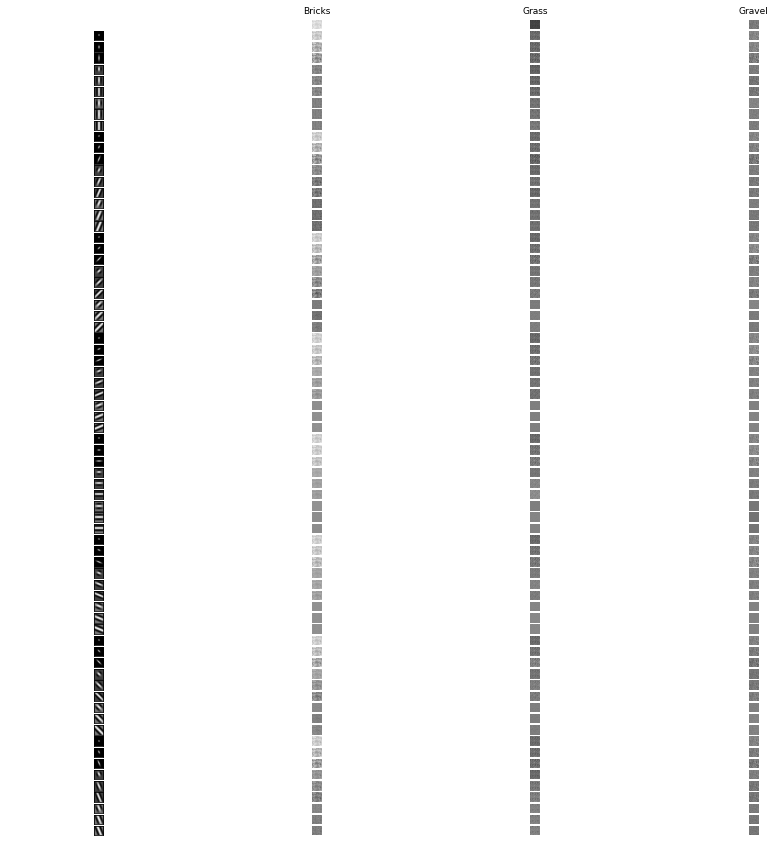

In [475]:
fig, axes = plt.subplots(nrows=len(kernels)+1, ncols=4, figsize=(15,15))
axes[0][0].axis('off')

for label, img, ax in zip(reference_labels, reference_images, axes[0][1:]):
    ax.imshow(img,'gray')
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for kernel, ax_row in zip( kernels, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(kernel,'gray')
#     ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ind = 0
    for ax in ax_row[1:]:
        ax.imshow(feature(reference_images[ind],kernel),'gray')
        ind+=1
        ax.axis('off')
plt.savefig('../Outputs/p3.jpg')
plt.show()

In [476]:
len(kernels)

72

# p4 & p5:

In [477]:
def mse(test,reference,kernell):
    mse = np.sum((features2(test,kernell)-features2(reference,kernell))**2)
    return mse

In [478]:
def classify(test,references,kernell):
    mses = []
    for ref in references:
        mses.append(mse(test,ref,kernell))
    output = reference_labels[np.argmin(mses)]
    return output

In [479]:
classifier_labels = []
score = 0
counter = 0
for img in test_images:
    output = classify(img,reference_images,kernels)
    if output == test_labels[counter]:
        score += 1
    classifier_labels.append(output)
    counter += 1
score = (score/len(test_images))*100

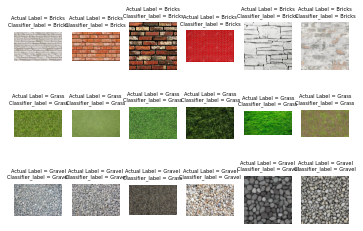

In [483]:
for i in range(len(classifier_labels)):
    plt.subplot(3,6,i+1)
    plt.imshow(cv2.cvtColor(test_images_rgb[i],cv2.COLOR_BGR2RGB),'gray')
    plt.axis('off')
    plt.title('Actual Label = {}\nClassifier_label = {}'.format(test_labels[i],classifier_labels[i]),size = 5)
    plt.savefig('../Outputs/p5a.jpg')
plt.show()
#     print(classifier_labels[i],test_labels[i])

## confusion matrix:

In [481]:
from sklearn import metrics
import seaborn as sns
import pandas as pd

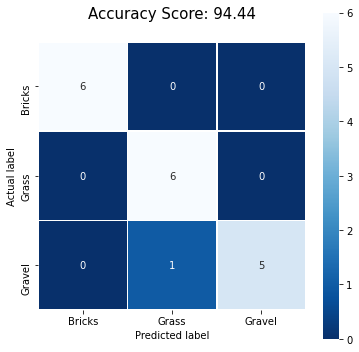

In [484]:
#confusion matrix:
# predictions1 = prediction(x_test)
# score1 = scores(x_test, y_test)

cm = metrics.confusion_matrix(test_labels, classifier_labels)

df_cm = pd.DataFrame(cm, 
  index = reference_labels,
  columns = reference_labels)

# print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True, fmt="d", linewidths=0.5, \
            square = True, cmap = 'Blues_r');

# ax.set_ylim(bottom, top)
# plt.ylim(3,0)

plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}\n'.format(score)
plt.title(all_sample_title, size = 15)
plt.savefig('../Outputs/p5b.jpg')
plt.show()

# p6:

## theta:

In [517]:
kernels = []
for theta in range(3):
    theta = theta / 3. * np.pi
    for sigma in (1,3,5):
        for gamma in (1,0.5,0.25):
            kernel = cv2.getGaborKernel((21,21), sigma, theta, 10,\
                                        gamma, 0, cv2.CV_32F)
#             kernel /= math.sqrt((kernel * kernel).sum())
            kernels.append(kernel)

In [518]:
len(kernels)

27

In [519]:
classifier_labels = []
score = 0
counter = 0
for img in test_images:
    output = classify(img,reference_images,kernels)
    if output == test_labels[counter]:
        score += 1
    classifier_labels.append(output)
    counter += 1
score = (score/len(test_images))*100

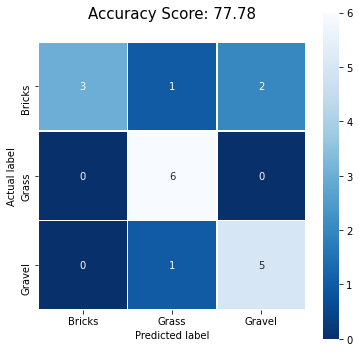

In [520]:
#confusion matrix:
# predictions1 = prediction(x_test)
# score1 = scores(x_test, y_test)

cm = metrics.confusion_matrix(test_labels, classifier_labels)

df_cm = pd.DataFrame(cm, 
  index = reference_labels,
  columns = reference_labels)

# print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True, fmt="d", linewidths=0.5, \
            square = True, cmap = 'Blues_r');

# ax.set_ylim(bottom, top)
# plt.ylim(3,0)

plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}\n'.format(score)
plt.title(all_sample_title, size = 15)
plt.savefig('../Outputs/p6a.jpg')
plt.show()

## ksize:

In [521]:
kernels = []
for theta in range(8):
    theta = theta / 8. * np.pi
    for sigma in (1,3,5):
        for gamma in (1,0.5,0.25):
            kernel = cv2.getGaborKernel((7,7), sigma, theta, 10,\
                                        gamma, 0, cv2.CV_32F)
#             kernel /= math.sqrt((kernel * kernel).sum())
            kernels.append(kernel)

In [522]:
len(kernels)

72

In [523]:
classifier_labels = []
score = 0
counter = 0
for img in test_images:
    output = classify(img,reference_images,kernels)
    if output == test_labels[counter]:
        score += 1
    classifier_labels.append(output)
    counter += 1
score = (score/len(test_images))*100

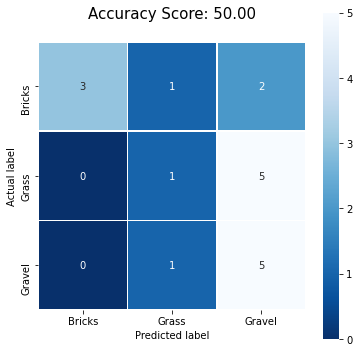

In [524]:
#confusion matrix:
# predictions1 = prediction(x_test)
# score1 = scores(x_test, y_test)

cm = metrics.confusion_matrix(test_labels, classifier_labels)

df_cm = pd.DataFrame(cm, 
  index = reference_labels,
  columns = reference_labels)

# print(cm)

plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True, fmt="d", linewidths=0.5, \
            square = True, cmap = 'Blues_r');

# ax.set_ylim(bottom, top)
# plt.ylim(3,0)

plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.2f}\n'.format(score)
plt.title(all_sample_title, size = 15)
plt.savefig('../Outputs/p6b.jpg')
plt.show()